# Introduction  

The purpose of this assignment is to explore and implement two foundational algorithms for AI exploration in partially observable environments -- akin to hiking to the peak of a mountain in a dense fog. The two algortithms are Hill Climbing and Simulated Annealing and will be explored in that order.

## Preliminary imports  

The numpy and pandas packages will be utilized for their numeric and tabular operations. For visualization in the simulated annealing section we will be relying on the matplotlib and seaborn libraries. Finally, the warning package was added to suppress precision errors related to the estimation of extremely small double values (smaller than $\frac{1}{2^{-52}}$) when calculating the sigmoid function.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# swats away annoying float calculation error msg for very small numbers.
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning) 

## The Sigmoid Function  

Foundational for many neural networks and probabilistic machine learning algorithms.

In [2]:
def sigmoid(x):
    return 1/(1+np.e**(-x))

\clearpage

## Objective function  

Below we formulate the `gate_errors()` function which takes as input the weights - $W_x$, $W_y$, and $W_b$ - as a list-like object as well as the string name of the desired boolean gate and returns a sum of errors across from the 4 possible input combinations.

In [3]:
def gate_errors(weights, boolean="AND"):
    if boolean.upper() == "AND":
        out = np.array(([0],[0],[0],[1]))
    elif boolean.upper() == "OR":
        out = np.array(([0],[1],[1],[1]))
    elif boolean.upper() == "NOR":
        out = np.array(([1],[0],[0],[0]))
    elif boolean.upper() == "NAND":
        out = np.array(([1],[1],[1],[0]))
    else:
        raise Exception("Unrecognized value passed to boolean argument.")
    
    domain = np.array(([0,0], [0,1], [1,0], [1,1]))
      
    def _error(inputs, output):
        inpt =np.append(inputs, 1)
        pred = np.dot(np.reshape(weights, 3,),inpt)
        return np.abs(output-sigmoid(pred))
    
    errors = 0
    for i in range(len(out)):
        errors += _error(domain[i], out[i])      
    return errors[0]

\clearpage

## Generate Child Nodes  

The below function, `tree_level()`, takes 3 arguments: a list-like object containing three weights, the string name of the desired boolean gate, and the number of child nodes to be generated. It returns a pandas DataFrame object with each child's weights and error.

In [4]:
def tree_level(weights, boolean="AND", nodes=6):
    _weights = weights.copy()
    w1 = [weights[0]]
    w2 = [weights[1]]
    wb = [weights[2]]
    err = [gate_errors(weights, boolean)]
    
    for i in range(nodes-1): 
        _weights += np.random.randint(-2,3,3)
        w1.append(_weights[0])
        w2.append(_weights[1])
        wb.append(_weights[2])
        err.append(gate_errors(_weights, boolean))
    return pd.DataFrame({"w1": w1, "w2": w2, "wb": wb, "err": err})

\clearpage

# Hill Climbing  

## Describe the problem you are solving.  

I am building an artificial neuron that serves as a boolean function and would like to find the three weights of the neuron ($W_x$, $W_y$, and $W_b$). Using the Hill Climbinig algorithm I will trace the detailed process of finding the optimal values of the weights using printed outputs from Python in a Jupyter Notebook. In tandem with this tracing, I will also implement the algorithm as a computer program to find the optimal values of the weights.

## Implementation of the algorithm  

Below is an implementation of the Hill Climbing algorithm. It utilizes the `gate_error()` and `tree_level()` functions built above to guide and explore the various state spaces and (hopefully) find optimal values for $W_x$, $W_y$, and $W_b$; given the convex nature of the problem Hill Climbing should work great. The only input for this function is the string name of the desired boolean logic gate. Note: The number of children from each parent node is fixed at 6, but could easily be altered. 

In [5]:
def hill_climb(boolean):
    df = tree_level([0,0,0], boolean)
    print("Layer 1")
    print(df)
    best = df["err"].nsmallest(1).iloc[0]
    best_weights = df.nsmallest(1, "err").iloc[:, :-1]

    df_a = df
    iteration = 2
    while True:
        print("\n")
        print(f"Layer {iteration}")
        if df_a["err"].nsmallest(1).iloc[0] <= best:    
            df_b =  tree_level(df.nsmallest(1, "err").iloc[:, :-1].values.tolist()[0], boolean)
            print(df_b)
            if df_b["err"].nsmallest(1).iloc[0] < best:
                best = df_b["err"].nsmallest(1).iloc[0]
                best_weights = df_b.nsmallest(1, "err").iloc[:, :-1]
                df_a = df_b
                iteration += 1
            else:
                print("No improvement, local minimum reached.")
                break
    return best, best_weights

## Hill Climbing with the "OR" Logic Gate

In [6]:
b, b_weights = hill_climb("OR")

print("\n\n"+f"Best Weights: {b_weights.values[0]}"+"\n")
print(f"Lowest Error: {b:.2f}")

Layer 1
   w1  w2  wb       err
0   0   0   0  2.000000
1   2   0   0  1.238406
2   1  -1   2  1.316367
3   0  -2   3  1.537883
4   2  -4   2  2.279580
5   1  -5   0  2.744262


Layer 2
   w1  w2  wb       err
0   2   0   0  1.238406
1   4   2   1  0.786088
2   2   4   2  0.901591
3   4   4   3  0.954413
4   6   2   2  0.899164
5   8   0   2  1.000091


Layer 3
   w1  w2  wb       err
0   2   0   0  1.238406
1   4   2  -2  0.756392
2   4   0  -1  1.094852
3   6  -2  -2  1.238406
4   5  -3  -4  2.166814
5   6  -3  -4  1.867337


Layer 4
   w1  w2  wb       err
0   2   0   0  1.238406
1   3   2   2  0.906387
2   4   2   0  0.639662
3   2   4  -1  0.592002
4   0   4  -1  1.094852
5  -2   6   1  1.469721


Layer 5
   w1  w2  wb       err
0   2   0   0  1.238406
1   1   2   2  0.952902
2   0   1   0  1.537883
3   2  -1   2  1.215151
4   3  -2   0  1.697164
5   5  -1   1  1.240224
No improvement, local minimum reached.


Best Weights: [ 2  4 -1]

Lowest Error: 0.59


\clearpage

## Hill Climbing with the "NOR" Logic Gate

In [7]:
b, b_weights = hill_climb("NOR")

print("\n\n"+f"Best Weights: {b_weights.values[0]}"+"\n")
print(f"Lowest Error: {b:.2f}")

Layer 1
   w1  w2  wb       err
0   0   0   0  2.000000
1   1  -2   0  1.619203
2   3  -4   0  1.739502
3   5  -6   1  1.773162
4   5  -7   1  1.537883
5   6  -8   0  1.617066


Layer 2
   w1  w2  wb       err
0   5  -7   1  1.537883
1   3  -5   3  1.895215
2   2  -7   1  1.241974
3   4  -6  -1  1.731970
4   4  -4  -2  1.883270
5   3  -2  -4  1.300854


Layer 3
   w1  w2  wb       err
0   5  -7   1  1.537883
1   7  -6  -1  2.229497
2   5  -4   0  2.242352
3   3  -4  -1  1.737751
4   1  -2  -2  1.215151
5   0  -3   0  1.094852


Layer 4
   w1  w2  wb       err
0   5  -7   1  1.537883
1   6  -9   2  1.388720
2   6 -11   2  1.166417
3   4  -9   0  1.488830
4   6 -10  -2  1.865290
5   8  -8  -3  1.993324
No improvement, local minimum reached.


Best Weights: [ 0 -3  0]

Lowest Error: 1.09


\clearpage

## Hill Climbing with the "OR" Logic Gate

In [8]:
b, b_weights = hill_climb("NAND")

print("\n\n"+f"Best Weights: {b_weights.values[0]}"+"\n")
print(f"Lowest Error: {b:.2f}")

Layer 1
   w1  w2  wb       err
0   0   0   0  2.000000
1  -1   0   0  2.000000
2   0  -2  -1  2.462117
3  -1  -4  -3  2.934012
4   1  -3  -2  2.623149
5   1  -3  -2  2.623149


Layer 2
   w1  w2  wb       err
0   0   0   0  2.000000
1   2   0  -1  2.462117
2   3  -2   1  1.898783
3   5  -4   3  1.760834
4   3  -4   2  1.737751
5   4  -5   3  1.809931


Layer 3
   w1  w2  wb       err
0   0   0   0  2.000000
1  -2  -1   0  2.159282
2  -4   0  -2  2.761594
3  -5  -2  -4  2.979434
4  -4   0  -4  2.964028
5  -4   0  -5  2.986614
No improvement, local minimum reached.


Best Weights: [ 3 -4  2]

Lowest Error: 1.74


\clearpage

# Simulated Annealing on "OR" Boolean Gate

In [9]:
def simulated_annealing(temp_decay):
    # lists for plotting
    error_list = []
    delta_E_list = []
    iteration = np.arange(1,101,1)

    # Gradient Descent works best with reasonable starting values
    weights_old = [10, 5, -10]
    weights_new = [10, 5, -10]
    T = [1/(1+temp_decay*i) for i in range(100)]
    for i in range(100):
        error_old = gate_errors(weights_old, "or")
        error_new = gate_errors(weights_new, "or")
        error_list.append(error_new)

        delta_E = (error_new - error_old)
        delta_E_list.append(delta_E)

        if delta_E <= 0:
            error_old = error_new
            weights_old = weights_new
            weights_new = weights_old + np.random.randint(-2,3,3)
        elif np.e**(-delta_E/T[i]) > np.random.rand():
            error_old = error_new
            weights_old = weights_new
            weights_new = weights_old + np.random.randint(-2,3,3)

    print(f"Final Error: {error_old:0.2f}") 
    print(f"Final Weights: {weights_new}")
    
    sns.lineplot(x=iteration, y=error_list, label="objective function")
    sns.lineplot(x=iteration, y=T, label="temperature")
    sns.scatterplot(x=iteration, y=delta_E_list, label="delta E", color="black", s=25)
    plt.legend()
    plt.title("Logic Gate Simulated Annealing with 100 Iterations")
    plt.show()

\clearpage

## Case 1: Temperature is $\frac{1}{1+0.01 t}$

Final Error: 2.99
Final Weights: [ 12 -14 -19]


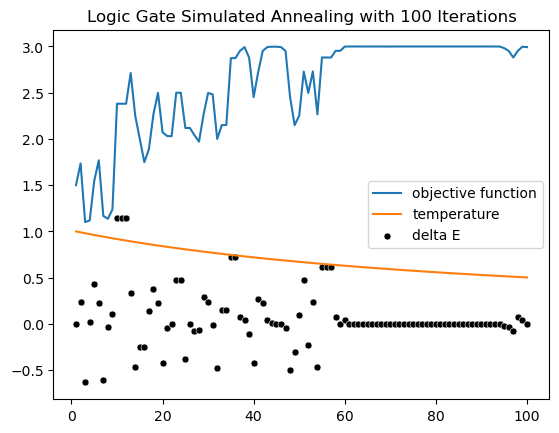

In [10]:
simulated_annealing(0.01)

\clearpage

## Case 2: Temperature is $\frac{1}{1+0.1 t}$

Final Error: 1.92
Final Weights: [  6   3 -12]


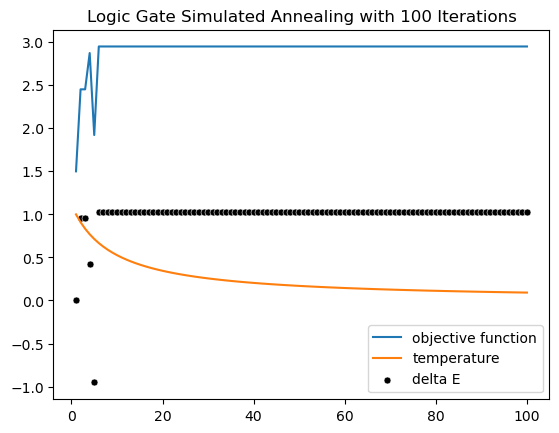

In [11]:
simulated_annealing(0.1)

\clearpage

## Case 3: Temperature is $\frac{1}{1+t}$

Final Error: 1.22
Final Weights: [ 7  7 -9]


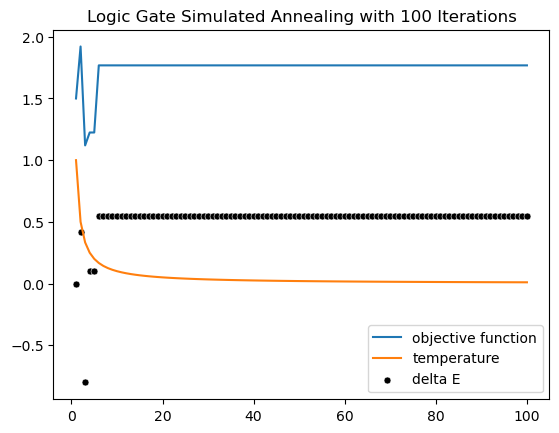

In [12]:
simulated_annealing(1)

\clearpage

## Test Algorithm: Random Exploration Without Annealing

In [13]:
error_old = 5
# lists for plotting
error_list = []
delta_E_list = []
iteration = np.arange(1,101,1)

# Gradient Descent works best with reasonable starting values
weights_old = [10, 5, -10]
weights_new = [10, 5, -10]
for i in range(100):
    error_old = gate_errors(weights_old, "and")
    error_new = gate_errors(weights_new, "and")
    error_list.append(error_new)
    
    delta_E = (error_new - error_old)
    delta_E_list.append(delta_E)
    
    if delta_E <= 0:
        error_old = error_new
        weights_old = weights_new
        weights_new = weights_old + np.random.randint(-2,3,3)
    else:
        weights_new = weights_old + np.random.randint(-2,3,3)

print(f"Final Error: {error_old:0.2f}") 
print(f"Final Weights: {weights_new}")

Final Error: 0.00
Final Weights: [ 26  27 -44]


\clearpage

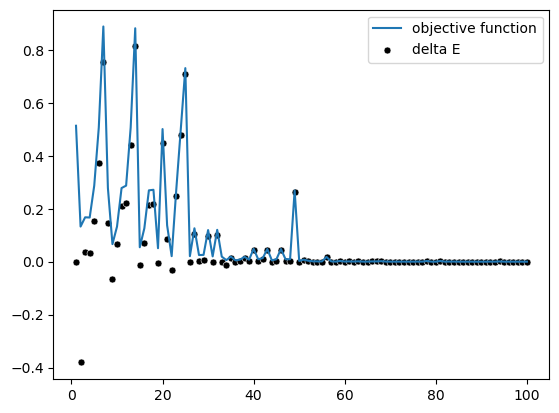

In [15]:
sns.lineplot(x=iteration, y=error_list, label="objective function")
#sns.scatterplot(x=iteration, y=T, label="temperature")
sns.scatterplot(x=iteration, y=delta_E_list, label="delta E", color="black", s=25)
plt.legend()
plt.show()

# Conclusions and Findings

The process of tracing and implementing the Hill Climbing and Simulated Annealing algorithms yielded several challenges and insights. First, we overcame our preconceived notion of treating this AI problem as a classification problem. After this, the code and understanding of the Hill Climbing Algorithm came fairly quickly. Next, the weights suggested by the Simulated Annealing models (discussed below) went against our intuition and caused us to look over the code for errors and debug for a couple hours only to realize there were no errors.  

We found that the Hill Climbing algorithm performed fine, but would get stuck on local optima. We went into the Simulated Annealing algorithm expecting improved results because, theoretically, the tempering process would "knock" us away from local solutions. However, this was not the case. What ended up happenning was the random process introduced drove us away from our solution and would eventually find a local solution no better or worse than the solution found by the Hill Climbing algorithm. This solution tended to get worse as the learning rate ($t$) became smaller.  

Out of curiosity, we re-ran the algorithm with stochastic search but without the stochastic updating. As seen in the above visualization, a solution was yielded with by far the best objective function output (almost 0).  